In [1]:
import os
import sys
import logging
import warnings
import json
import copy
import re
import time
import itertools
from collections import defaultdict
import unidecode
import numpy as np
import pandas as pd
import pandas_profiling
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn import linear_model

import gensim
import spacy 
from spacy import displacy
from spacy.tokens import Doc
from spacy.lang.en import English

from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud

import pyLDAvis.gensim
pyLDAvis.enable_notebook()

logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO

sns.set_style('darkgrid')
sns.set_context('notebook')

warnings.filterwarnings('ignore')
np.random.seed(42)

E:\softwares\Anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
TYPES = {
    'country': str,
    'description': str,
    'designation': str,
    'points': int,
    'price': float,
    'province': str,
    'region_1': str,
    'region_2': str,
    'taster_name': str,
    'taster_twitter_handle': str,
    'title': str,
    'variety': str,
    'winery': str
}

df = pd.read_csv('winemag-data-130k-v2.csv', dtype=TYPES, header=0, index_col=0)
df.head(30)

country                                        description  \
0       Italy  Aromas include tropical fruit, broom, brimston...   
1    Portugal  This is ripe and fruity, a wine that is smooth...   
2          US  Tart and snappy, the flavors of lime flesh and...   
3          US  Pineapple rind, lemon pith and orange blossom ...   
4          US  Much like the regular bottling from 2012, this...   
5       Spain  Blackberry and raspberry aromas show a typical...   
6       Italy  Here's a bright, informal red that opens with ...   
7      France  This dry and restrained wine offers spice in p...   
8     Germany  Savory dried thyme notes accent sunnier flavor...   
9      France  This has great depth of flavor with its fresh ...   
10         US  Soft, supple plum envelopes an oaky structure ...   
11     France  This is a dry wine, very spicy, with a tight, ...   
12         US  Slightly reduced, this wine offers a chalky, t...   
13      Italy  This is dominated by oak and oak-driven aromas...   
14         US  Building on 150 years and six generations of w...   
15    Germany  Zesty orange peels and apple notes abound in t...   
16  Argentina  Baked plum, molasses, balsamic vinegar and che...   
17  Argentina  Raw black-cherry aromas are direct and simple ...   
18      Spain  Desiccated blackberry, leather, charred wood a...   
19         US  Red fruit aromas pervade on the nose, with cig...   
20         US  Ripe aromas of dark berries mingle with ample ...   
21         US  A sleek mix of tart berry, stem and herb, alon...   
22      Italy  Delicate aromas recall white flower and citrus...   
23         US  This wine from the Geneseo district offers aro...   
24      Italy  Aromas of prune, blackcurrant, toast and oak c...   
25         US  Oak and earth intermingle around robust aromas...   
26      Italy  Pretty aromas of yellow flower and stone fruit...   
27      Italy  Aromas recall ripe dark berry, toast and a whi...   
28      Italy  Aromas suggest mature berry, scorched earth, a...   
29         US  Clarksburg is becoming a haven for Chenin Blan...   

                                          designation  points  price  \
0                                        Vulkà Bianco      87    NaN   
1                                            Avidagos      87   15.0   
2                                                 NaN      87   14.0   
3                                Reserve Late Harvest      87   13.0   
4                  Vintner's Reserve Wild Child Block      87   65.0   
5                                        Ars In Vitro      87   15.0   
6                                             Belsito      87   16.0   
7                                                 NaN      87   24.0   
8                                               Shine      87   12.0   
9                                         Les Natures      87   27.0   
10                                     Mountain Cuvée      87   19.0   
11                                                NaN      87   30.0   
12                                                NaN      87   34.0   
13                                              Rosso      87    NaN   
14                                                NaN      87   12.0   
15                                              Devon      87   24.0   
16                                              Felix      87   30.0   
17                                Winemaker Selection      87   13.0   
18  Vendimia Seleccionada Finca Valdelayegua Singl...      87   28.0   
19                                                NaN      87   32.0   
20                                      Vin de Maison      87   23.0   
21                                                NaN      87   20.0   
22                                          Ficiligno      87   19.0   
23                                Signature Selection      87   22.0   
24                                              Aynat      87   35.0   
25                       

In [3]:
pandas_profiling.ProfileReport(df,check_correlation=False, bins=10)

In [4]:
print('country: ', len(df['country'].unique()))
print('province: ', len(df['province'].unique()))
print('variety: ', len(df['variety'].unique()))

country:  44
province:  426
variety:  708


In [5]:
columns_to_merge = ['country', 'description', 'designation', 'province', 
                   'region_1', 'region_2', 'title', 'variety', 'winery']
df[columns_to_merge] = df[columns_to_merge].fillna('')

In [6]:
re_pattern = re.compile(r'-{1,2}[a-z]\.[a-z]\.?')  # Pattern to strip out name initials
def row2str(row):
    return re_pattern.sub(' ', unidecode.unidecode('. '.join(row[columns_to_merge])).lower())

start_time = time.time()
points, texts = zip(*[
    (row['points'], row2str(row))
    for _, row in df.iterrows()])
print('Converting dataframe took {} s'.format(time.time() - start_time))

print('points: ', len(points))
print('texts: ', len(texts))
print('Points:', points[0], ', text:', texts[0])

Converting dataframe took 107.7798388004303 s
points:  129971
texts:  129971
Points: 87 , text: italy. aromas include tropical fruit, broom, brimstone and dried herb. the palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.. vulka bianco. sicily & sardinia. etna. . nicosia 2013 vulka bianco  (etna). white blend. nicosia


In [7]:
Doc.set_extension('filtered_tokens', default='')

def filter_token(t):
    return not (t.is_stop or t.is_punct or t.is_space)

def tokenize_component(doc):
    doc._.set('filtered_tokens', tuple(t.lemma_ for t in doc if filter_token(t)))
    return doc

nlp = English()
# nlp = spacy.load('en', disable=['parser', 'ner'])
nlp.add_pipe(tokenize_component)
print('NLP pipeline: ', nlp.pipe_names)

def gen_split_tokens(texts):
    return (doc._.filtered_tokens for doc in nlp.pipe(texts))

def gen_bigram(texts):
    texts = list(texts)
    bigram = gensim.models.phrases.Phrases(
        texts, 
        common_terms=set(["of", "with", "without", "and", "or", "the", "a"]))
    for t in texts:
        yield bigram[t]
        
def gen_tokens(texts):
    return gen_bigram(gen_split_tokens(t for t in texts))

NLP pipeline:  ['tokenize_component']


In [8]:
%time tokenized_texts = list(gen_tokens(texts))
print('tokenized_texts: ', len(tokenized_texts))
for i in range(3):
    print('Example tokens: ', tokenized_texts[i][:10])

INFO : collecting all words and their counts
INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO : PROGRESS: at sentence #10000, processed 415391 words and 185379 word types
INFO : PROGRESS: at sentence #20000, processed 830649 words and 304116 word types
INFO : PROGRESS: at sentence #30000, processed 1244068 words and 400409 word types
INFO : PROGRESS: at sentence #40000, processed 1662136 words and 484584 word types
INFO : PROGRESS: at sentence #50000, processed 2076837 words and 560043 word types
INFO : PROGRESS: at sentence #60000, processed 2494864 words and 627447 word types
INFO : PROGRESS: at sentence #70000, processed 2905359 words and 688050 word types
INFO : PROGRESS: at sentence #80000, processed 3322384 words and 748169 word types
INFO : PROGRESS: at sentence #90000, processed 3741182 words and 805012 word types
INFO : PROGRESS: at sentence #100000, processed 4153006 words and 856502 word types
INFO : PROGRESS: at sentence #110000, processed 4568291 wo

Wall time: 4min 21s
tokenized_texts:  129971
Example tokens:  ['italy', 'aroma', 'include', 'tropical_fruit', 'broom', 'brimstone', 'dry_herb', 'palate', 'not', 'overly']
Example tokens:  ['portugal', 'ripe', 'fruity', 'wine', 'smooth', 'structure', 'firm', 'tannin', 'fill', 'juicy']
Example tokens:  ['tart', 'snappy', 'flavor', 'lime', 'flesh_rind', 'dominate', 'green', 'pineapple', 'poke', 'crisp']


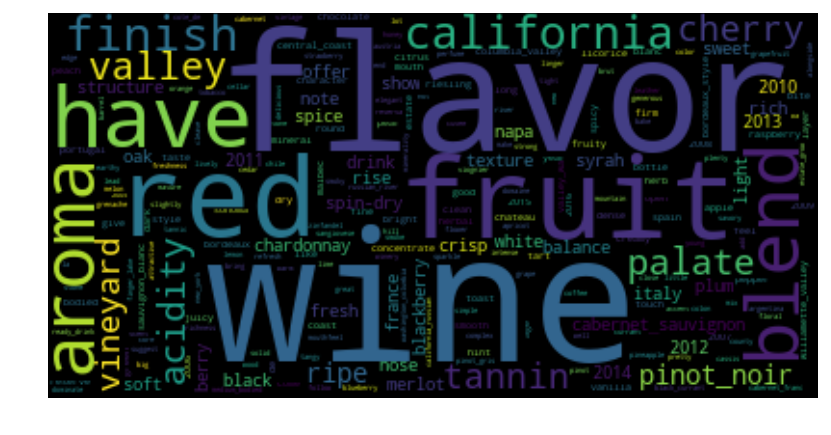

In [9]:
frequency = defaultdict(int)
for tokens in tokenized_texts:
    for token in tokens:
        frequency[token] += 1
        
wc = WordCloud(max_words=1000)
wc.fit_words(frequency)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [10]:
# Create a dictionary (This wil take a couple of minutes)
%time id2word = gensim.corpora.Dictionary(tokenized_texts)
print('id2word: ', id2word)

INFO : adding document #0 to Dictionary(0 unique tokens: [])
INFO : adding document #10000 to Dictionary(25264 unique tokens: ['2013', 'alongside', 'apple', 'aroma', 'bianco_etna']...)
INFO : adding document #20000 to Dictionary(35280 unique tokens: ['2013', 'alongside', 'apple', 'aroma', 'bianco_etna']...)
INFO : adding document #30000 to Dictionary(41598 unique tokens: ['2013', 'alongside', 'apple', 'aroma', 'bianco_etna']...)
INFO : adding document #40000 to Dictionary(46260 unique tokens: ['2013', 'alongside', 'apple', 'aroma', 'bianco_etna']...)
INFO : adding document #50000 to Dictionary(49913 unique tokens: ['2013', 'alongside', 'apple', 'aroma', 'bianco_etna']...)
INFO : adding document #60000 to Dictionary(52818 unique tokens: ['2013', 'alongside', 'apple', 'aroma', 'bianco_etna']...)
INFO : adding document #70000 to Dictionary(55287 unique tokens: ['2013', 'alongside', 'apple', 'aroma', 'bianco_etna']...)
INFO : adding document #80000 to Dictionary(57581 unique tokens: ['2013

Wall time: 4.59 s
id2word:  Dictionary(65613 unique tokens: ['2013', 'alongside', 'apple', 'aroma', 'bianco_etna']...)


In [11]:
# ignore words that appear in less than 25 documents or more than 50% documents
id2word.filter_extremes(no_below=25, no_above=0.5)
id2word.compactify()
print('id2word: ', id2word, len(id2word))

INFO : discarding 56417 tokens: [('nicosia', 11), ('unripened', 3), ('vulka', 2), ('avidagos', 8), ('dos_avidagos', 6), ('wine', 66883), ('flavor', 65303), ('rainstorm', 14), ('guava_mango', 24), ('honey_drizzle', 15)]...
INFO : keeping 9196 tokens which were in no less than 25 and no more than 64985 (=50.0%) documents
INFO : resulting dictionary: Dictionary(9196 unique tokens: ['2013', 'alongside', 'apple', 'aroma', 'bianco_etna']...)


id2word:  Dictionary(9196 unique tokens: ['2013', 'alongside', 'apple', 'aroma', 'bianco_etna']...) 9196


In [12]:
%time corpus = [id2word.doc2bow(tokens) for tokens in tokenized_texts]

Wall time: 2.96 s


In [13]:
for k, v in itertools.islice(id2word.items(), 5):
    print('{}: {}'.format(k, v))

0: 2013
1: alongside
2: apple
3: aroma
4: bianco_etna


***TF-IDF based score regression***

In [14]:
# TF-IDF transformed corpus
# TF-IDF will take a couple of seconds on the full corpus
%time tfidf_model = gensim.models.TfidfModel(corpus, id2word=id2word)

INFO : collecting document frequencies
INFO : PROGRESS: processing document #0
INFO : PROGRESS: processing document #10000
INFO : PROGRESS: processing document #20000
INFO : PROGRESS: processing document #30000
INFO : PROGRESS: processing document #40000
INFO : PROGRESS: processing document #50000
INFO : PROGRESS: processing document #60000
INFO : PROGRESS: processing document #70000
INFO : PROGRESS: processing document #80000
INFO : PROGRESS: processing document #90000
INFO : PROGRESS: processing document #100000
INFO : PROGRESS: processing document #110000
INFO : PROGRESS: processing document #120000
INFO : calculating IDF weights for 129971 documents and 9195 features (3404564 matrix non-zeros)


Wall time: 820 ms


In [15]:
tf_idf_corpus = tfidf_model[corpus]
print('tf_idf_corpus: ', type(tf_idf_corpus), len(tf_idf_corpus))
%time tfidf_csr = gensim.matutils.corpus2csc(tf_idf_corpus, num_terms=len(id2word), num_docs=len(tf_idf_corpus)).T
print('tfidf_csr: ', type(tfidf_csr), tfidf_csr.shape)

tf_idf_corpus:  <class 'gensim.interfaces.TransformedCorpus'> 129971
Wall time: 13.6 s
tfidf_csr:  <class 'scipy.sparse.csr.csr_matrix'> (129971, 9196)


In [16]:
# Print some of the TF-IDF transformations
for i in range(3):
    print('Example tokens: ', tokenized_texts[i][:2])
    bow_test = id2word.doc2bow(tokenized_texts[i])
    tfidf_sample = tfidf_model[bow_test]
    print(tfidf_sample[:2])
    print([tfidf_csr[i,tfidf_sample[x][0]] for x in range(2)])

Example tokens:  ['italy', 'aroma']
[(0, 0.0895143334086485), (1, 0.14925704145627114)]
[0.0895143334086485, 0.14925704145627114]
Example tokens:  ['portugal', 'ripe']
[(23, 0.12576857557397123), (24, 0.17186830518444265)]
[0.12576857557397123, 0.17186830518444265]
Example tokens:  ['tart', 'snappy']
[(0, 0.09608243288830132), (25, 0.06299137039640883)]
[0.09608243288830132, 0.06299137039640883]


In [17]:
x_train, x_test, y_train, y_test = train_test_split(
    tfidf_csr, np.array(points), test_size=0.05, random_state=42)

print('x_train: ', type(x_train), x_train.shape)
print('y_train: ', type(y_train), y_train.shape)
print('x_test: ', type(x_test), x_test.shape)
print('y_test: ', type(y_test), y_test.shape)

x_train:  <class 'scipy.sparse.csr.csr_matrix'> (123472, 9196)
y_train:  <class 'numpy.ndarray'> (123472,)
x_test:  <class 'scipy.sparse.csr.csr_matrix'> (6499, 9196)
y_test:  <class 'numpy.ndarray'> (6499,)


In [18]:
linreg_model = linear_model.Ridge(alpha=0.1)
%time linreg_model.fit(x_train, y_train)

Wall time: 4.03 s


Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

y_train_pred:  (123472,)
Mean absolute error: 1.1390811396331408
Variance score: 0.7722088011555057


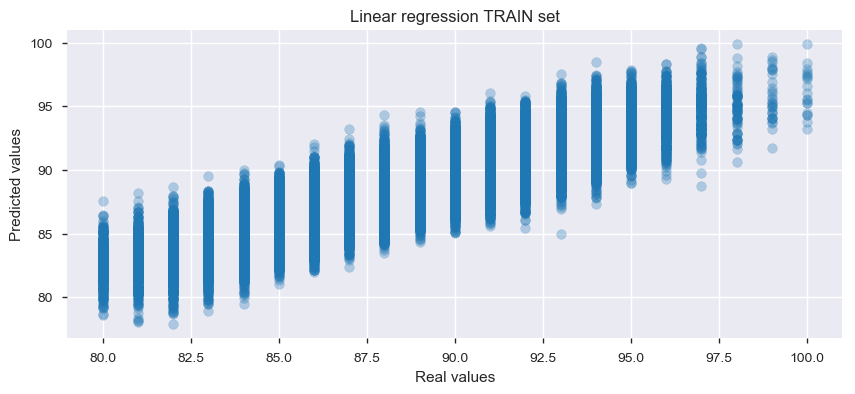

In [19]:
# Predictions from train set
y_train_pred = linreg_model.predict(x_train)
print('y_train_pred: ', y_train_pred.shape)

print('Mean absolute error: {}'.format(mean_absolute_error(y_train, y_train_pred)))
print('Variance score: {}'.format(r2_score(y_train, y_train_pred)))

# Plot predictions
plt.figure(figsize=(10, 4))
plt.scatter(y_train, y_train_pred, alpha=.3)
plt.title('Linear regression TRAIN set')
plt.xlabel('Real values')
plt.ylabel('Predicted values')
plt.show()

y_test_pred:  (6499,)
Mean absolute error: 1.226381822401849
Variance score: 0.7419234203463394


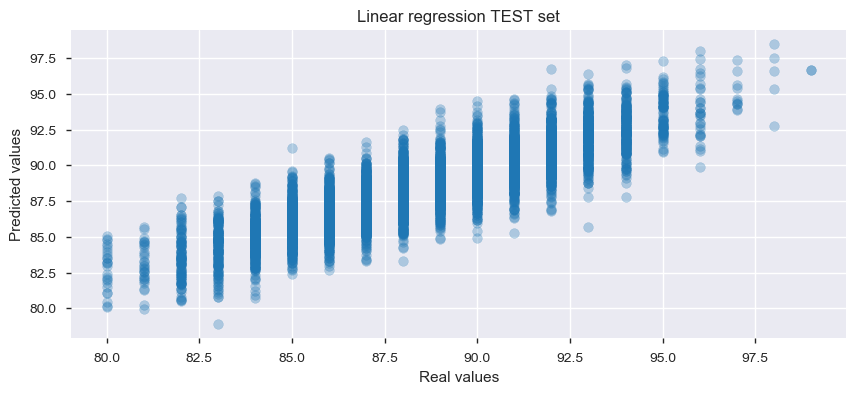

In [20]:
# Predictions from test set
y_test_pred = linreg_model.predict(x_test)
print('y_test_pred: ', y_test_pred.shape)

print('Mean absolute error: {}'.format(mean_absolute_error(y_test, y_test_pred)))
print('Variance score: {}'.format(r2_score(y_test, y_test_pred)))

# Plot predictions
plt.figure(figsize=(10, 4))
plt.scatter(y_test, y_test_pred, alpha=.3)
plt.title('Linear regression TEST set')
plt.xlabel('Real values')
plt.ylabel('Predicted values')
plt.show()

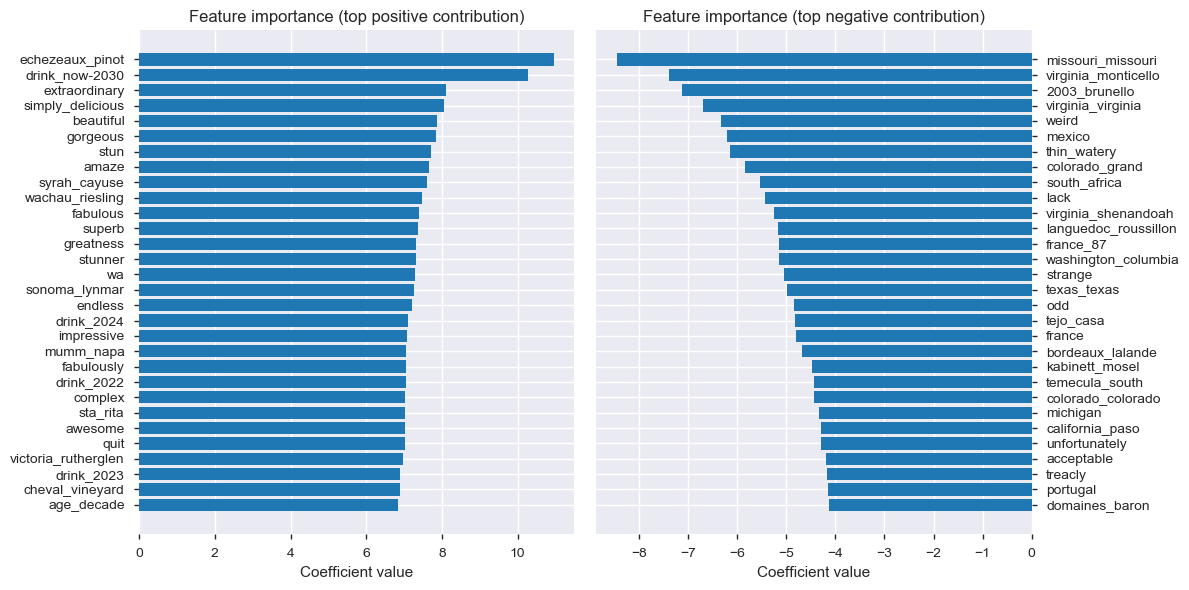

In [21]:
# Find top features

# Top features contributing positive effect
max_indices = linreg_model.coef_.argsort()[-30:][::-1]
max_values = linreg_model.coef_[max_indices]

names = [id2word.get(i) for i in max_indices]
y_pos = np.arange(len(names))

fig = plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
ax1.barh(y_pos, max_values, align='center')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(names)
ax1.invert_yaxis()  # labels read top-to-bottom
ax1.set_xlabel('Coefficient value')
ax1.set_title('Feature importance (top positive contribution)')

# Top features contributing negative effect 
min_indices = linreg_model.coef_.argsort()[:30]
min_values = linreg_model.coef_[min_indices]

names = [id2word.get(i) for i in min_indices]
y_pos = np.arange(len(names))

ax2 = plt.subplot(122)
ax2.barh(y_pos, min_values, align='center')
ax2.set_yticks(y_pos)
ax2.set_yticklabels(names)
ax2.invert_yaxis()  # labels read top-to-bottom
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax2.set_xlabel('Coefficient value')
ax2.set_title('Feature importance (top negative contribution)')
plt.tight_layout()
plt.show()

***LDA based score regression***

In [22]:
### LDA topic-modelling on a subset of documents
num_lda_topics = 50
%time lda_model = gensim.models.LdaMulticore(corpus, num_topics=num_lda_topics, id2word=id2word, passes=2)
# Serialise the LDA model
lda_model.save('lda_wiki.model')
# Serialise corpus transformed to LDA space
%time gensim.corpora.MmCorpus.serialize('wiki_lda.mm', lda_model[mm_corpus])
lda_model.print_topics(10)

INFO : using symmetric alpha at 0.02
INFO : using symmetric eta at 0.02
INFO : using serial LDA version on this node
INFO : running online LDA training, 50 topics, 2 passes over the supplied corpus of 129971 documents, updating every 14000 documents, evaluating every ~129971 documents, iterating 50x with a convergence threshold of 0.001000
INFO : training LDA model using 7 processes
INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/129971, outstanding queue size 1
INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/129971, outstanding queue size 2
INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/129971, outstanding queue size 3
INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/129971, outstanding queue size 4
INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/129971, outstanding queue size 5
INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #12000/129971, outstanding queue size 6


INFO : PROGRESS: pass 0, dispatched chunk #43 = documents up to #88000/129971, outstanding queue size 21
INFO : PROGRESS: pass 0, dispatched chunk #44 = documents up to #90000/129971, outstanding queue size 21
INFO : PROGRESS: pass 0, dispatched chunk #45 = documents up to #92000/129971, outstanding queue size 21
INFO : PROGRESS: pass 0, dispatched chunk #46 = documents up to #94000/129971, outstanding queue size 20
INFO : PROGRESS: pass 0, dispatched chunk #47 = documents up to #96000/129971, outstanding queue size 21
INFO : merging changes from 14000 documents into a model of 129971 documents
INFO : topic #38 (0.020): 0.049*"california" + 0.034*"chardonnay" + 0.021*"have" + 0.015*"valley" + 0.012*"sonoma" + 0.010*"fruit" + 0.010*"vineyard" + 0.009*"finish" + 0.009*"cabernet_sauvignon" + 0.008*"zinfandel"
INFO : topic #23 (0.020): 0.030*"white" + 0.018*"fruit" + 0.017*"aroma" + 0.015*"have" + 0.014*"finish" + 0.013*"blend" + 0.013*"palate" + 0.010*"italy" + 0.010*"sauvignon_blanc" + 0

INFO : topic #2 (0.020): 0.022*"chardonnay" + 0.016*"white" + 0.014*"aroma" + 0.013*"acidity" + 0.012*"finish" + 0.012*"blend" + 0.011*"have" + 0.011*"palate" + 0.009*"ripe" + 0.009*"fruit"
INFO : topic #48 (0.020): 0.037*"red" + 0.030*"fruit" + 0.026*"portugal" + 0.017*"have" + 0.017*"tannin" + 0.013*"ripe" + 0.013*"acidity" + 0.011*"rich" + 0.011*"structure" + 0.010*"black"
INFO : topic #41 (0.020): 0.032*"france" + 0.020*"blanc" + 0.019*"fruit" + 0.017*"acidity" + 0.016*"crisp" + 0.014*"texture" + 0.013*"rise" + 0.013*"ripe" + 0.011*"champagne" + 0.011*"have"
INFO : topic #36 (0.020): 0.021*"fruit" + 0.015*"have" + 0.012*"acidity" + 0.011*"chateau" + 0.009*"tannin" + 0.009*"pinot_noir" + 0.009*"vineyard" + 0.008*"balance" + 0.008*"france" + 0.008*"fresh"
INFO : topic diff=0.123147, rho=0.132453
INFO : merging changes from 3971 documents into a model of 129971 documents
INFO : topic #17 (0.020): 0.022*"blend" + 0.019*"chardonnay" + 0.015*"sparkle" + 0.015*"apple" + 0.015*"fruit" + 0.

INFO : PROGRESS: pass 1, dispatched chunk #37 = documents up to #76000/129971, outstanding queue size 21
INFO : PROGRESS: pass 1, dispatched chunk #38 = documents up to #78000/129971, outstanding queue size 20
INFO : PROGRESS: pass 1, dispatched chunk #39 = documents up to #80000/129971, outstanding queue size 21
INFO : PROGRESS: pass 1, dispatched chunk #40 = documents up to #82000/129971, outstanding queue size 21
INFO : merging changes from 14000 documents into a model of 129971 documents
INFO : topic #28 (0.020): 0.089*"red" + 0.052*"blend" + 0.021*"syrah" + 0.017*"fruit" + 0.015*"have" + 0.014*"aroma" + 0.013*"columbia_valley" + 0.012*"cherry" + 0.011*"cabernet_sauvignon" + 0.010*"tannin"
INFO : topic #42 (0.020): 0.025*"vineyard" + 0.018*"fruit" + 0.011*"california" + 0.009*"finish" + 0.009*"aroma" + 0.009*"red" + 0.009*"blend" + 0.009*"valley" + 0.008*"have" + 0.008*"black"
INFO : topic #41 (0.020): 0.037*"france" + 0.023*"blanc" + 0.020*"acidity" + 0.020*"fruit" + 0.018*"crisp"

INFO : topic #17 (0.020): 0.033*"sparkle" + 0.027*"blend" + 0.020*"brut" + 0.018*"apple" + 0.017*"chardonnay" + 0.013*"fruit" + 0.012*"white" + 0.012*"acidity" + 0.011*"palate" + 0.011*"citrus"
INFO : topic #27 (0.020): 0.035*"cabernet_sauvignon" + 0.015*"california" + 0.015*"red" + 0.014*"north_coast" + 0.012*"fruit" + 0.011*"palate" + 0.011*"oak" + 0.011*"finish" + 0.011*"have" + 0.009*"chardonnay"
INFO : topic diff=0.147368, rho=0.122183
INFO : merging changes from 14000 documents into a model of 129971 documents
INFO : topic #16 (0.020): 0.035*"red" + 0.032*"blend" + 0.030*"fruit" + 0.026*"tannin" + 0.024*"bordeaux_style" + 0.020*"barrel_sample" + 0.020*"france" + 0.014*"ripe" + 0.013*"acidity" + 0.013*"bordeaux_saint"
INFO : topic #45 (0.020): 0.038*"central_coast" + 0.024*"santa_barbara" + 0.021*"county" + 0.021*"palate" + 0.020*"nose" + 0.020*"california" + 0.019*"chardonnay" + 0.016*"aroma" + 0.015*"vineyard" + 0.013*"have"
INFO : topic #38 (0.020): 0.073*"california" + 0.071*"

Wall time: 46.6 s


INFO : saving LdaState object under lda_wiki.model.state, separately None
INFO : saved lda_wiki.model.state
INFO : saving LdaMulticore object under lda_wiki.model, separately ['expElogbeta', 'sstats']
INFO : storing np array 'expElogbeta' to lda_wiki.model.expElogbeta.npy
INFO : not storing attribute dispatcher
INFO : not storing attribute id2word
INFO : not storing attribute state
INFO : saved lda_wiki.model


NameError: name 'mm_corpus' is not defined

INFO : topic #34 (0.020): 0.052*"italy" + 0.022*"aroma" + 0.018*"fruit" + 0.018*"red" + 0.017*"blend" + 0.012*"sangiovese" + 0.012*"have" + 0.012*"cherry" + 0.011*"spice" + 0.011*"note"
INFO : topic #14 (0.020): 0.034*"italy" + 0.027*"aroma" + 0.025*"tannin" + 0.024*"cherry" + 0.022*"black" + 0.022*"palate" + 0.019*"red" + 0.017*"offer" + 0.013*"berry" + 0.010*"alongside"
INFO : topic #10 (0.020): 0.035*"france" + 0.028*"fruit" + 0.026*"red" + 0.023*"acidity" + 0.021*"cote_de" + 0.020*"rise" + 0.019*"pinot_noir" + 0.012*"de_provence" + 0.012*"premier_cru" + 0.012*"light"
INFO : topic #9 (0.020): 0.022*"red" + 0.021*"valley" + 0.020*"black" + 0.019*"cherry" + 0.017*"tannin" + 0.013*"palate" + 0.012*"aroma" + 0.010*"finish" + 0.009*"fruit" + 0.009*"offer"
INFO : topic #18 (0.020): 0.031*"finish" + 0.031*"aroma" + 0.020*"berry" + 0.018*"palate" + 0.018*"spain" + 0.016*"plum" + 0.014*"fruit" + 0.014*"feel" + 0.013*"argentina" + 0.012*"chile"
INFO : topic #16 (0.020): 0.036*"red" + 0.033*"b

[(34,
  '0.052*"italy" + 0.022*"aroma" + 0.018*"fruit" + 0.018*"red" + 0.017*"blend" + 0.012*"sangiovese" + 0.012*"have" + 0.012*"cherry" + 0.011*"spice" + 0.011*"note"'),
 (14,
  '0.034*"italy" + 0.027*"aroma" + 0.025*"tannin" + 0.024*"cherry" + 0.022*"black" + 0.022*"palate" + 0.019*"red" + 0.017*"offer" + 0.013*"berry" + 0.010*"alongside"'),
 (10,
  '0.035*"france" + 0.028*"fruit" + 0.026*"red" + 0.023*"acidity" + 0.021*"cote_de" + 0.020*"rise" + 0.019*"pinot_noir" + 0.012*"de_provence" + 0.012*"premier_cru" + 0.012*"light"'),
 (9,
  '0.022*"red" + 0.021*"valley" + 0.020*"black" + 0.019*"cherry" + 0.017*"tannin" + 0.013*"palate" + 0.012*"aroma" + 0.010*"finish" + 0.009*"fruit" + 0.009*"offer"'),
 (18,
  '0.031*"finish" + 0.031*"aroma" + 0.020*"berry" + 0.018*"palate" + 0.018*"spain" + 0.016*"plum" + 0.014*"fruit" + 0.014*"feel" + 0.013*"argentina" + 0.012*"chile"'),
 (16,
  '0.036*"red" + 0.033*"blend" + 0.031*"fruit" + 0.027*"tannin" + 0.025*"bordeaux_style" + 0.021*"barrel_sample"

In [23]:

lda_topics  = lda_model.get_topics()
print('lda_topics: ', type(lda_topics), lda_topics.shape)

lda_corpus = lda_model[corpus]
print('lda_corpus: ', type(lda_corpus), len(lda_corpus))
%time lda_features_csr = gensim.matutils.corpus2csc(lda_corpus, num_terms=num_lda_topics, num_docs=len(lda_corpus)).T
print('lda_features: ', type(lda_features_csr), lda_features_csr.shape)

lda_topics:  <class 'numpy.ndarray'> (50, 9196)
lda_corpus:  <class 'gensim.interfaces.TransformedCorpus'> 129971
Wall time: 56.9 s
lda_features:  <class 'scipy.sparse.csr.csr_matrix'> (129971, 50)


In [24]:
pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
18     0.058806  0.023965       1        1  7.552810
14     0.075285 -0.013888       2        1  5.257035
8     -0.134242  0.102094       3        1  4.327078
38     0.005540  0.089121       4        1  4.041235
19    -0.092149 -0.215990       5        1  3.573586
34     0.028732  0.001238       6        1  3.327414
41    -0.214214 -0.076985       7        1  3.300568
23    -0.156367  0.141865       8        1  3.197818
20     0.105133 -0.009467       9        1  3.176424
28     0.123177 -0.051043      10        1  3.056045
15     0.090977  0.039141      11        1  2.764073
26    -0.074770  0.124135      12        1  2.707768
3      0.105155  0.024227      13        1  2.687424
4      0.076877  0.010469      14        1  2.545972
12     0.105398  0.002580      15        1  2.510309
48    -0.043696 -0.174396      16        1  2.494003
46     0.082965 -0.023224      17        1  2.222755
45    -0.058407  0.143411      18        1  2.069981
31     0.139428  0.040480      19        1  1.975436
29     0.080843 -0.006276      20        1  1.852608
1     -0.079072  0.108857      21        1  1.766636
5      0.118578  0.034334      22        1  1.745808
47     0.101531 -0.015310      23        1  1.712489
10    -0.110639 -0.130129      24        1  1.697065
13     0.073086 -0.020377      25        1  1.666307
6     -0.038811 -0.190425      26        1  1.657114
16    -0.021219 -0.188357      27        1  1.614104
24     0.017615  0.065146      28        1  1.603828
21     0.051288 -0.047191      29        1  1.577950
17    -0.155480  0.076576      30        1  1.525978
30     0.060486  0.032636      31        1  1.496701
32     0.093685 -0.003584      32        1  1.467435
49    -0.098492  0.142784      33        1  1.417448
11     0.094910  0.030156      34        1  1.305633
7      0.048821  0.062927      35        1  1.236879
33    -0.167739  0.010357      36        1  1.172691
42     0.051679  0.011344      37        1  1.010269
43    -0.110644 -0.038091      38        1  0.977793
39    -0.112162  0.010464      39        1  0.912904
37    -0.033241  0.015319      40        1  0.794649
27     0.043851  0.005152      41        1  0.769416
2     -0.051528  0.089369      42        1  0.763822
44     0.034964 -0.002983      43        1  0.747750
9      0.104837  0.002838      44        1  0.743567
35    -0.085524 -0.007954      45        1  0.740217
22    -0.052211 -0.074240      46        1  0.701777
0     -0.050997  0.042157      47        1  0.696422
40     0.059197 -0.023006      48        1  0.641091
25    -0.056259 -0.131418      49        1  0.609000
36    -0.034983 -0.038810      50        1  0.586911, topic_info=     Category          Freq                Term         Total  loglift  \
term                                                                     
40    Default  58885.000000                 red  58885.000000  30.0000   
95    Default  28153.000000          pinot_noir  28153.000000  29.0000   
176   Default  38100.000000          california  38100.000000  28.0000   
60    Default  37386.000000              valley  37386.000000  27.0000   
186   Default  13798.000000                napa  13798.000000  26.0000   
6     Default  41157.000000               blend  41157.000000  25.0000   
143   Default  21780.000000              france  21780.000000  24.0000   
115   Default  13875.000000              merlot  13875.000000  23.0000   
228   Default  24510.000000          chardonnay  24510.000000  22.0000   
656   Default  12765.000000     columbia_valley  12765.000000  21.0000   
15    Default  20306.000000               italy  20306.000000  20.0000   
300   Default  13565.000000                rise  13565.000000  19.0000   
603   Default  14695.000000               syrah  14695.000000  18.0000   
22    Default  19703.000000               white  19703.000000  17.0000   
453   Default  11

In [25]:
x_train_lda, x_test_lda, y_train_lda, y_test_lda = train_test_split(
    lda_features_csr, np.array(points), test_size=0.05, random_state=42)

print('x_train_lda: ', type(x_train_lda), x_train_lda.shape)
print('y_train_lda: ', type(y_train_lda), y_train_lda.shape)
print('x_test_lda: ', type(x_test_lda), x_test_lda.shape)
print('y_test_lda: ', type(y_test_lda), y_test_lda.shape)

x_train_lda:  <class 'scipy.sparse.csr.csr_matrix'> (123472, 50)
y_train_lda:  <class 'numpy.ndarray'> (123472,)
x_test_lda:  <class 'scipy.sparse.csr.csr_matrix'> (6499, 50)
y_test_lda:  <class 'numpy.ndarray'> (6499,)


In [26]:
linreg_lda_model = linear_model.Ridge(alpha=5)
%time linreg_lda_model.fit(x_train_lda, y_train_lda)

Wall time: 860 ms


Ridge(alpha=5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

y_train_lda_pred:  (123472,)
Mean absolute error: 2.224069024231412
Variance score: 0.17559100500384417


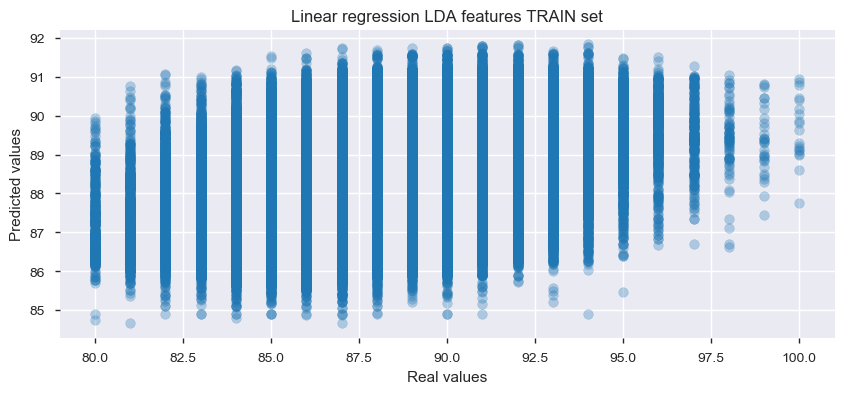

In [27]:
# Predictions from train set
y_train_lda_pred = linreg_lda_model.predict(x_train_lda)
print('y_train_lda_pred: ', y_train_lda_pred.shape)

print('Mean absolute error: {}'.format(mean_absolute_error(y_train_lda, y_train_lda_pred)))
print('Variance score: {}'.format(r2_score(y_train_lda, y_train_lda_pred)))

# Plot predictions
plt.figure(figsize=(10, 4))
plt.scatter(y_train_lda, y_train_lda_pred, alpha=.3)
plt.title('Linear regression LDA features TRAIN set')
plt.xlabel('Real values')
plt.ylabel('Predicted values')
plt.show()

y_test_lda_pred:  (6499,)
Mean absolute error: 2.2520053646957665
Variance score: 0.1823886296505176


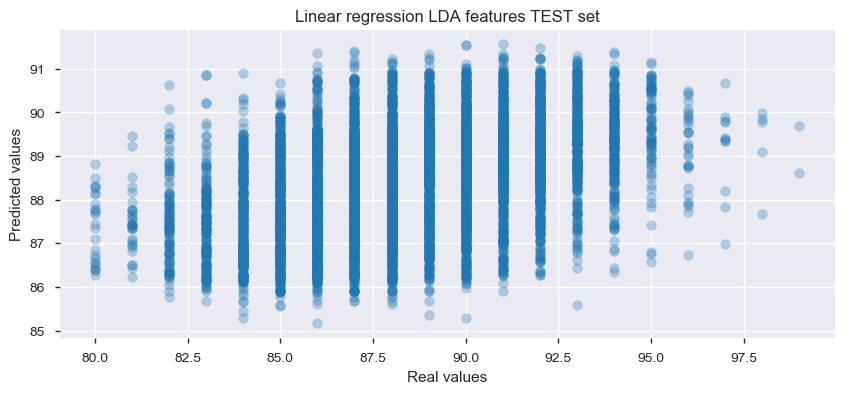

In [28]:
# Predictions from test set
y_test_lda_pred = linreg_lda_model.predict(x_test_lda)
print('y_test_lda_pred: ', y_test_lda_pred.shape)

print('Mean absolute error: {}'.format(mean_absolute_error(y_test_lda, y_test_lda_pred)))
print('Variance score: {}'.format(r2_score(y_test_lda, y_test_lda_pred)))

# Plot predictions
plt.figure(figsize=(10, 4))
plt.scatter(y_test_lda, y_test_lda_pred, alpha=.3)
plt.title('Linear regression LDA features TEST set')
plt.xlabel('Real values')
plt.ylabel('Predicted values')
plt.show()

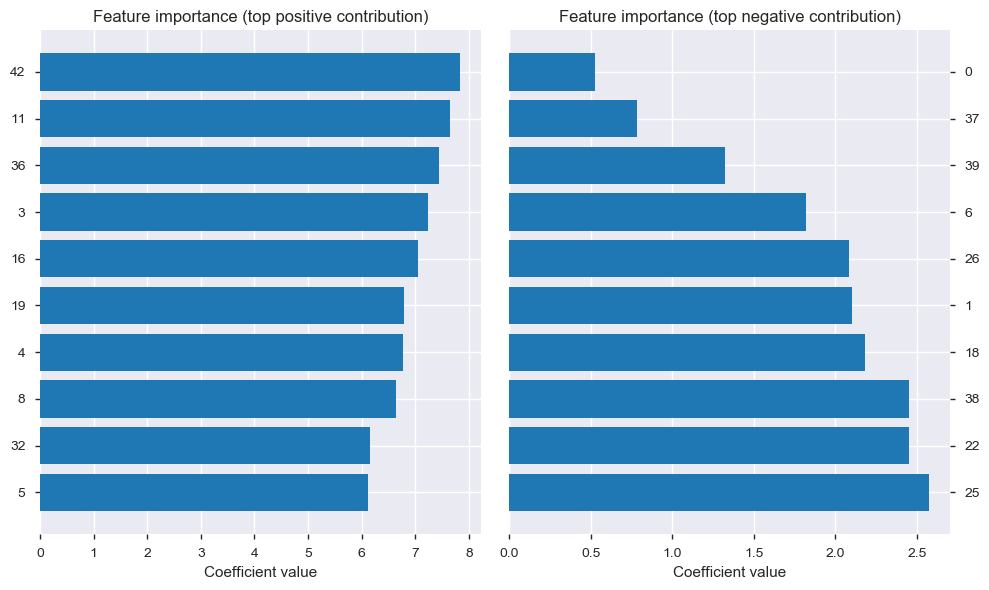

In [29]:
# Find top features

# Top postive contributing features
max_indices = linreg_lda_model.coef_.argsort()[-10:][::-1]
max_values = linreg_lda_model.coef_[max_indices]
y_pos = np.arange(len(max_indices))

fig = plt.figure(figsize=(10, 6))
ax1 = plt.subplot(121)
ax1.barh(y_pos, max_values, align='center')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(max_indices)
ax1.invert_yaxis()  # labels read top-to-bottom
ax1.set_xlabel('Coefficient value')
ax1.set_title('Feature importance (top positive contribution)')


# Top negative contributing features
min_indices = linreg_lda_model.coef_.argsort()[:10]
min_values = linreg_lda_model.coef_[min_indices]
y_pos = np.arange(len(min_indices))

ax2 = plt.subplot(122)
ax2.barh(y_pos, min_values, align='center')
ax2.set_yticks(y_pos)
ax2.set_yticklabels(min_indices)
ax2.invert_yaxis()  # labels read top-to-bottom
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax2.set_xlabel('Coefficient value')
ax2.set_title('Feature importance (top negative contribution)')
plt.tight_layout()
plt.show()

GOOD:


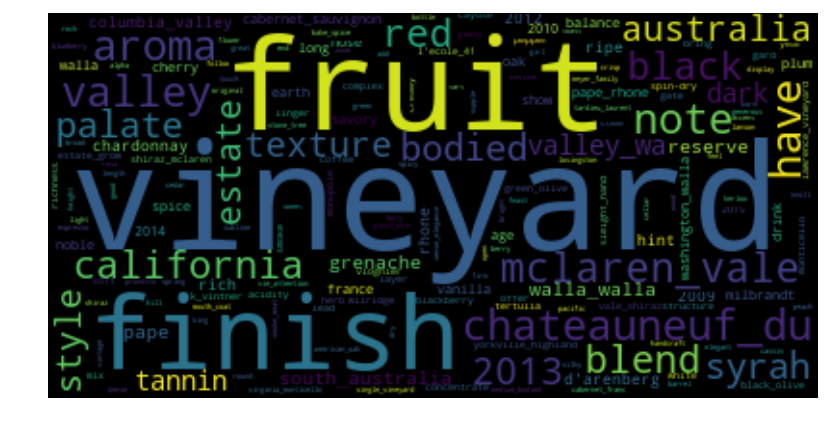

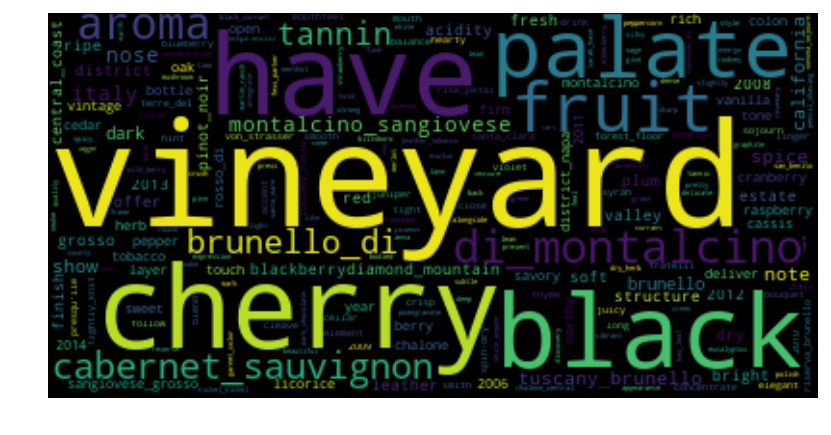




BAD:


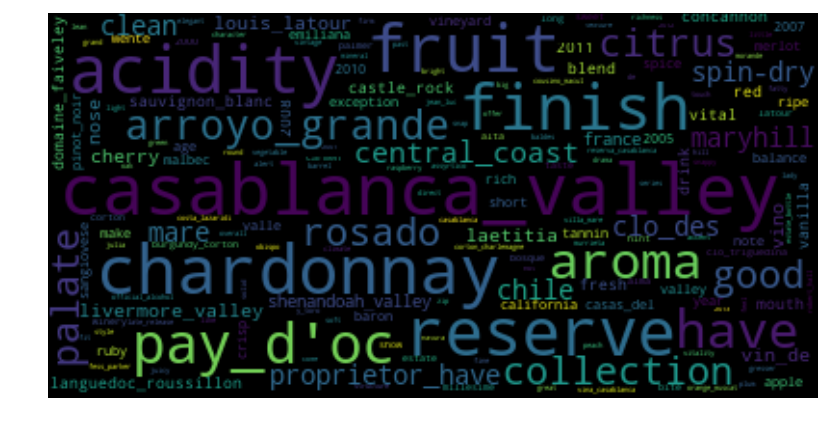

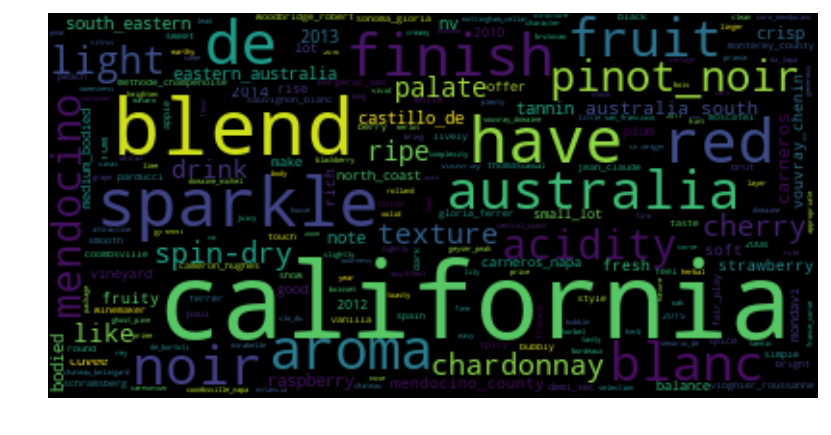

In [30]:
def show_topic(idx):
    freqs = {}
    for widx in range(lda_topics.shape[1]):
        freqs[id2word[widx]] = lda_topics[idx, widx]

    wc = WordCloud(max_words=1000)
    wc.fit_words(freqs)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
print('GOOD:')
show_topic(max_indices[0])
show_topic(max_indices[1])

print('\n\n')
print('BAD:')
show_topic(min_indices[0])
show_topic(min_indices[1])